# <b>Projekt 1. - Symulator Tomografu</b>
### <b>Autorzy:</b> Wiktoria Białasik 151436, Mateusz Czechowski 155921

## <u>Zastosowany język programowania oraz użyte biblioteki</u>
<p> W projekcie wykorzystano język programowania <b>Python</b> oraz posłużono się bibliotekami wymienionymi poniżej. Do przetwarzania obrazów i sygnałów zastosowano biblioteki takie jak <b> scipy, scikit-image, matplotlib, pydicom oraz Pillow</b>, które umożliwiają zaawansowaną analizę i wizualizację danych obrazowych. W celu wsparcia obliczeń numerycznych i matematycznych użyto bibliotek <b>numpy oraz scipy</b> , natomiast interaktywność aplikacji zapewniono dzięki wykorzystaniu <b>ipywidgets i IPython.display</b>. </p>
<p>Zastosowano <b>model stożkowy</b> symulacji tomografu. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
import numpy as np
import pydicom
import datetime
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from PIL import Image
import os
import ipywidgets as widgets
from IPython.display import display, clear_output 
from matplotlib import colors
import re
from ipywidgets import interact
from skimage.draw import line_nd
import scipy.ndimage
from scipy import signal
from scipy.ndimage import convolve
from sklearn.metrics import mean_squared_error
import cv2
import math

### Wybór odczytu pliku (DCIM/PNG) oraz opcja dodania filtrowania

In [2]:
def on_select(change):
    global file_type
    file_type = change['new']
    print(f'Wybrano: {file_type}')

file_selector = widgets.Dropdown(
    options=['JPG', 'DCIM'],
    description='Wybierz:',
    disabled=False,
)

file_selector.observe(on_select, names='value')
display(file_selector)

apply_filtering = widgets.Checkbox(value=False, description="Używanie filtrowania")
display(apply_filtering)

Dropdown(description='Wybierz:', options=('JPG', 'DCIM'), value='JPG')

Checkbox(value=False, description='Używanie filtrowania')

### Odczyt oraz wyświetlenie obrazu wejściowego - przy odczycie plików dicom również odczyt imienia oraz ID pacjenta i komentarzy

Dropdown(description='Pick image', index=7, options=('CT_ScoutView-large.dcm', 'CT_ScoutView.dcm', 'Kolo.dcm',…

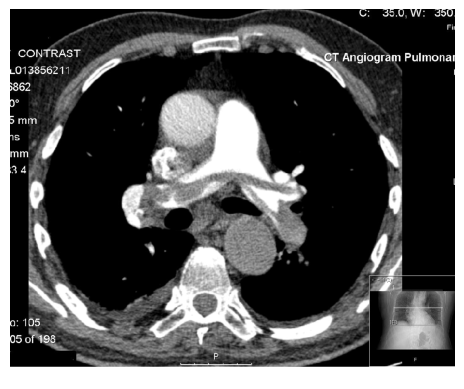

In [ ]:
image = None
filename = ''
type = file_selector.value
#metadata = None

sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

blur_kernel = np.array([[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]]) / 9.0

edge_kernel = np.array([[-1, -1, -1],
                        [-1, 9, -1],
                        [-1, -1, -1]], dtype='float')

if type == "JPG":
    examples_dir='example-data/png/'
    examples_list = [file for file in os.listdir(examples_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]
else:
    examples_dir='example-data/dicom/'
    examples_list = [file for file in os.listdir(examples_dir) if file.endswith(('.dcm'))]

filename_picker = widgets.Dropdown(
    options=examples_list,
    description="Pick image",
    disabled=False
)
#Funkcja pomocnicza do filtrowania Ram-Laka
def ramp_filter(length=21):
    if length % 2 == 0:
        length += 1  
    n = np.arange(-(length // 2), length // 2 + 1)
    filter_kernel = np.zeros_like(n, dtype=np.float32)
    for i, k in enumerate(n):
        if k == 0:
            filter_kernel[i] = 1 / 4  
        elif k % 2 == 0:
            filter_kernel[i] = 0
        else:
            filter_kernel[i] = -1 / (np.pi * k) ** 2
    return filter_kernel

# Funkcja do zastosowania różnych filtrów na obrazie
def apply_filter(image, kernel, filter_type):
    if filter_type == "gaussian":
        return scipy.ndimage.gaussian_filter(image, sigma=1)
    elif filter_type == "median":
        return scipy.ndimage.median_filter(image, size=3)
    elif filter_type == "convolution" and kernel is not None:
        image = signal.convolve2d(image, kernel)
        return image[2:-2,2:-2]
    elif filter_type == "convolution1d":
        kernel_f = ramp_filter()
        filtered = np.zeros_like(image, dtype=np.float32)
        for i in range(image.shape[0]):
            filtered[i] = np.convolve(image[i], kernel_f, mode='same')
        return filtered
    else:
        raise ValueError(f"Invalid filter_type: {filter_type}. Choose 'gaussian', 'median', or 'convolution'.")

def show(change):
    global dicom_data
    global image
    global filename
    global metadata
    clear_output(wait=True)
    display(filename_picker)
    selected_file = change['new']
    
    if selected_file:
        file_path = os.path.join(examples_dir, selected_file)
    
        if type == "JPG":
            image = mpimg.imread(file_path)
            if len(image.shape) == 3:
                image = np.mean(image, axis=2)
        else:
            dicom_data = pydicom.dcmread(file_path, force=True)

            image = dicom_data.pixel_array.astype(np.float32)

            image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
            image = image.astype(np.uint8)
            #print(metadata)
        
        if apply_filtering:
            apply_filter(image, sharpen_kernel, "gaussian")
        
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.show()
        filename = os.path.splitext(filename_picker.value)[0]
        print(filename)

filename_picker.observe(show, names='value')
display(filename_picker)


In [4]:
if type == "DCIM":
    def get_dicom_metadata():
        patient_name = dicom_data.PatientName
        patient_id = dicom_data.PatientID
        comments = dicom_data.ImageComments

        metadata = {
            "PatientName": patient_name,
            "PatientID": patient_id,
            "Comments": comments,
        }

        return metadata
    print(get_dicom_metadata())

{'PatientName': 'Doe^John', 'PatientID': '42', 'Comments': 'what a lovely image we have here...'}


### Określenie podstawowych parametrów symulacji, potrzebnych do generowania sinogramu i odwrotnej transformaty Radona. 
<p> Krok kątowy (<i>step</i>) określa kąt, o jaki obraca się emiter, liczba detektorów (<i>detectors_num</i>) to liczba detektorów rozmieszczonych na łuku naprzeciwko emitera promieniowania. Rozwartość kątowa (<i>span</i>) opisuje kąt, na którym rozmieszczone są detektory względem emitera promieniowania. </p>


In [5]:
step_widget = widgets.IntSlider(value=1, min=1, max=6, step=1, description='Krok ∆α:')
detector_count_widget = widgets.IntSlider(value=180, min=90, max=420, step=10, description='Liczba detektorów:')
span_widget = widgets.IntSlider(value=180, min=90, max=360, step=90, description='Rozwartość (l):')

display(step_widget, detector_count_widget, span_widget)

step = step_widget.value
detector_count = detector_count_widget.value
span = span_widget.value

IntSlider(value=1, description='Krok ∆α:', max=6, min=1)

IntSlider(value=180, description='Liczba detektorów:', max=420, min=90, step=10)

IntSlider(value=180, description='Rozwartość (l):', max=360, min=90, step=90)

### Wynikowy sinogram oraz wizualizacja postępu generowania sinogramu

<p> W funkcji <b>radon_transform</b> najpierw obliczane są parametry geometryczne obrazu za pomocą funkcji <b>compute_geometry</b>, która zwraca współrzędne środka obrazu (<i>x_center</i>, <i>y_center</i>) oraz promień (<i>radius</i>), uwzględniający dodatkowy margines (aby promień był odrobinę większy od obrazka wejściowego, co zapewnia lepszą dokładność). Następnie inicjalizowana jest macierz <i>sinogram</i>, której rozmiar zależy od liczby kątów projekcji (<i>int(2 * np.pi / step)</i>) oraz liczby detektorów (<i>detectors_num</i>).
Dla każdej iteracji <i>i</i> symulowane jest przesunięcie emitera, którego pozycja jest obliczana na podstawie kąta (<i>angle = i * step</i>). Detektory są rozmieszczone równomiernie w zakresie rozwartości (<i>span</i>) wokół przeciwległego punktu względem emitera, a ich pozycje (<i>det_pos</i>) są wyliczane dla każdego kąta.

Dla każdej pary emiter-detektor wyznaczana jest linia przechodząca przez piksele obrazu przy użyciu funkcji <b>line_nd(<i>emitter_pos</i>, <i>det_pos</i>, endpoint=True)</b>. Następnie wartości pikseli na ścieżce promienia są sumowane i normalizowane, tworząc wartość sinogramu <i>sinogram[i, det_idx]</i>.

Ostateczny sinogram (<i>sinogram_scaled</i>) jest zapisywany jako plik graficzny w katalogu <i>results/sinograms/</i>. Funkcja zwraca zarówno <i>sinogram</i>, jak i listę migawek sinogramu, na różnych etapach obliczeń.

</p>

In [6]:
def compute_geometry(shape, margin=0.18, fixed_radius = None):
    height, width = shape
    if fixed_radius is not None:
        radius = fixed_radius
    else:
        radius = math.floor(math.sqrt(height**2 + width**2) / 2)
    adjusted_radius = radius + int(radius * margin)
    return width // 2, height // 2, adjusted_radius

def radon_transform(image, step, detectors_num, span, filename, scans = None, show_plot = True, fixed_radius = None):
    step = np.radians(step)  
    span = np.radians(span)
    x_center, y_center, radius = compute_geometry(image.shape, fixed_radius=fixed_radius)
    if scans is None:
        sinogram = np.zeros((int(2 * np.pi / step), detectors_num))
    else:
        sinogram = np.zeros((scans, detectors_num))
    sinogram_snapshot = []
    
    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = np.array([x_center + radius * np.cos(angle), y_center + radius * np.sin(angle)]).astype(int)
        
        detector_first_pos = angle + np.pi - span / 2
        detector_last_pos = angle + np.pi + span / 2
        det_angles = np.linspace(detector_first_pos, detector_last_pos, detectors_num)
        
        for det_idx, det_angle in enumerate(det_angles):
            det_pos = np.array([x_center + radius * np.cos(det_angle), y_center + radius * np.sin(det_angle)]).astype(int)
            
            rr, cc = line_nd(emitter_pos, det_pos, endpoint=True)
            valid = (0 <= rr) & (rr < image.shape[0]) & (0 <= cc) & (cc < image.shape[1])
            
            bright_points = np.count_nonzero(valid)
            sum_bright = np.sum(image[rr[valid], cc[valid]])
            
            sinogram[i, det_idx] = sum_bright / bright_points if bright_points > 0 else 0

        if i % 10 == 0 or i == sinogram.shape[0] - 1:
            s_scaled = (255.0 / np.amax(sinogram)) * sinogram
            s_scaled = s_scaled.astype(np.uint8)
            s_image = Image.fromarray(s_scaled.T, mode='L')
            s_resized = s_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
            sinogram_snapshot.append(s_resized)

    sinogram_scaled = (255.0 / np.amax(sinogram)) * sinogram
    sinogram_scaled = sinogram_scaled.astype(np.uint8)
    sinogram_image = Image.fromarray(sinogram_scaled.T, mode='L')
    sinogram_resized = sinogram_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
    sinogram_resized.save(f'results/sinograms/{filename}.png')

    if show_plot is True:
        plt.imshow(sinogram_resized, cmap="gray")
        plt.axis('off')
        plt.show()

    return sinogram, sinogram_snapshot

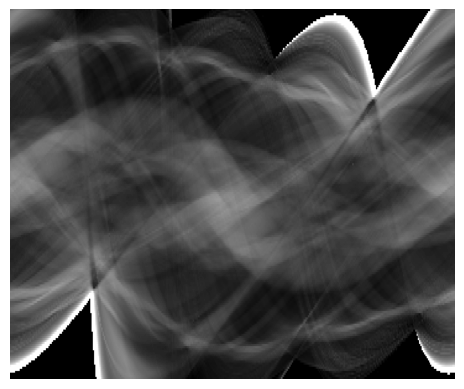

In [7]:
sinogram, sinogram_snapshots = radon_transform(image, step, detector_count, span, filename)

In [8]:
def display_sinogram(step):
    plt.imshow(sinogram_snapshots[step], cmap="gray")
    plt.axis('off')
    plt.show()
    
slider = widgets.IntSlider(value=0, min=0, max=len(sinogram_snapshots) - 1, step=1)
interact(display_sinogram, step=slider)


interactive(children=(IntSlider(value=0, description='step', max=36), Output()), _dom_classes=('widget-interac…

<function __main__.display_sinogram(step)>

### Wynikowy obraz po rekonstrukcji odwrotną transformatą Radona oraz wizualizacja postępu generowania obrazu

<p>Uzyskany sinogram skalowany jest za pomocą funkcji <b>apply_filter(sinogram, edge_kernel, "convolution1d")</b></p>
<p>W funkcji <b>inverse_radon_transform</b> inicjalizowane są macierze <i>result</i> oraz <i>norm_matrix</i>, które przechowują odpowiednio sumowane wartości intensywności oraz liczbę nałożonych projekcji w poszczególnych pikselach.
Dla każdej iteracji <i>i</i> wykonywane jest przekształcenie odwrotne dla konkretnego kąta projekcji (<i>angle = i * step</i>). Emiter jest umiejscowiony na okręgu wokół obrazu, a detektory rozmieszczone wzdłuż przedziału kątowego (<i>span</i>). Każda para emiter-detektor wyznacza linię projekcji, która jest obliczana za pomocą funkcji <b>line_nd(emitter_pos, det_pos, endpoint=True)</b>.

Wyniki projekcji są dodawane do macierzy <i>result</i>, a macierz <i>norm_matrix</i> zlicza liczbę nałożonych wartości dla poszczególnych pikseli. Co 10 iteracji generowane są pośrednie obrazy, w których wartości intensywności są dzielone przez odpowiednie elementy <i>norm_matrix</i>, a następnie skalowane i zapisywane w katalogu <i>results/template_images/</i>.

Po zakończeniu wszystkich iteracji końcowy obraz jest normalizowany, skalowany i zapisywany jako plik PNG w katalogu <i>results/recovered_images/png/</i>.

Funkcja zwraca macierz <i>result</i>, która stanowi odtworzony obraz na podstawie sinogramu.</p>

In [9]:
def inverse_radon_transform(sinogram, image_shape, step, span, filename, show_plt = True, fixed_radius = None, filter_sinogram = False, original_image = None):
    bladI = []

    if filter_sinogram:
        sinogram = apply_filter(sinogram, None, "convolution1d") #convolution1d

    x_center, y_center, radius = compute_geometry(image_shape, fixed_radius = fixed_radius)
    step = np.radians(step)
    span = np.radians(span)

    result = np.zeros(image_shape, dtype=np.float64)
    norm_matrix = np.zeros(image_shape, dtype=np.float64)

    output_dir = 'results/template_images/'
    os.makedirs(output_dir, exist_ok=True)

    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = np.array([x_center + radius * np.cos(angle), y_center + radius * np.sin(angle)], dtype=int)

        for j in range(sinogram.shape[1]):
            det_angle = angle + np.pi - span / 2 + j * span / sinogram.shape[1]
            det_pos = np.array([x_center + radius * np.cos(det_angle), y_center + radius * np.sin(det_angle)], dtype=int)

            rr, cc = line_nd(emitter_pos, det_pos, endpoint=True)

            valid_mask = (0 <= rr) & (rr < image_shape[0]) & (0 <= cc) & (cc < image_shape[1])
            valid_rr, valid_cc = rr[valid_mask], cc[valid_mask]

            result[valid_rr, valid_cc] += sinogram[i, j]
            norm_matrix[valid_rr, valid_cc] += 1

        if i % 10 == 0 and np.any(norm_matrix):  
            temp_result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix != 0)
            temp_result_scaled = (255.0 / np.amax(temp_result)) * temp_result if np.amax(temp_result) > 0 else temp_result
            temp_image = Image.fromarray(temp_result_scaled.astype(np.uint8), mode='L')
            temp_image.save(f'{output_dir}step_{i}.png')

        # Pomoc do eksperymentu
        if original_image is not None:  
            temp_result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix != 0)
            rmse_iter = np.sqrt(np.mean((temp_result - original_image) ** 2)) / 100
            bladI.append(rmse_iter)

    result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix != 0)
    
    result_scaled = (255.0 / np.amax(result)) * result if np.amax(result) > 0 else result
    result_image = Image.fromarray(result_scaled.astype(np.uint8), mode='L')

    output_path = f'results/recovered_images/png/{filename}.png'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    result_image.save(output_path)

    if show_plt is True:
        print("Obraz Wyjściowy")
        plt.imshow(result_image, cmap="gray")
        plt.axis('off')
        plt.show()


    if original_image is not None:
        return result, bladI
    else:
        return result


Obraz Wyjściowy


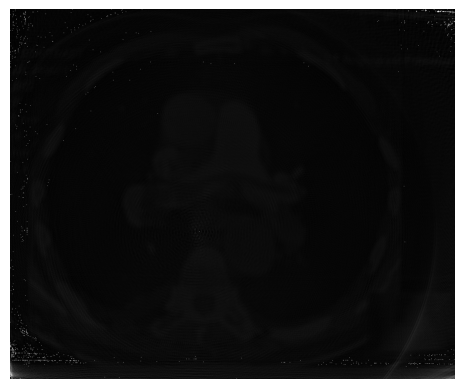

In [10]:
result= inverse_radon_transform(sinogram, image.shape, 1, 180, filename, filter_sinogram=apply_filtering)

In [61]:
print("Postęp generowania obrazu wyjściowegp")
image_folder = "results/template_images/"
def extract_number(filename):
    match = re.search(r"step_(\d+).png", filename)
    return int(match.group(1)) if match else float('inf')

images = sorted(
    [img for img in os.listdir(image_folder) if img.endswith('.png')],
    key=extract_number
)

slider = widgets.IntSlider(min=0, max=len(images)-1, step=1, description="Krok")

def update_image(step):
    img = plt.imread(os.path.join(image_folder, images[step]))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

widgets.interactive(update_image, step=slider)

Postęp generowania obrazu wyjściowegp


interactive(children=(IntSlider(value=0, description='Krok', max=35), Output()), _dom_classes=('widget-interac…

In [28]:
for f in os.listdir(image_folder):
    file_path = os.path.join(image_folder, f)
    if f.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)

### Zapis wynikowych plików i korekcja kontrastu

<p> W module zapisu obrazów zastosowano dwa formaty: PNG oraz DICOM. Funkcja <b>save_png</b> konwertuje tablicę obrazu (<i>image_array</i>) na obiekt obrazu <b>Image</b> w skali szarości (<i>mode='L'</i>) i zapisuje go w katalogu <i>results/recovered_images/png/</i> z nazwą <i>filename.png</i>.
Funkcja <b>save_dicom</b> generuje plik DICOM, zapisując w nim dodatkowe informacje medyczne. Domyślne wartości metadanych są identyczne z tymi odczytanymi z wejściowego obrazu (jeśli jego format to DICOM). Plik DICOM jest zapisywany w katalogu <i>results/recovered_images/dicom/</i> z nazwą <i>filename.dcm</i>.

</p>

<p> Funkcja <b>adjust_brightness</b> umożliwia regulację kontrastu obrazu wynikowego. 
Do modyfikacji kontrastu wykorzystywana jest funkcja <b>cv2.convertScaleAbs</b>, gdzie parametr <i>alpha</i> określa współczynnik kontrastu, a <i>beta</i> odpowiada za przesunięcie jasności (tutaj pozostaje bez zmian). Przetworzony obraz jest zapisywany w katalogu <i>results/recovered_images/png/</i> z dopiskiem <i>_contrast</i>.

Wybór współczynnika kontrastu możliwy jest w zakresie od 1.1 do 7.5, z krokiem 0.1.

Zmodyfikowany obraz można zapisać w formacie PNG/DICOM.
</p>

In [18]:
png_dir = "results/recovered_images/png/"
dicom_dir = "results/recovered_images/dicom/"
adjusted = [None]

def adjust_brightness(filename, contrast_factor=1.5):
    image_path = os.path.join(png_dir, f'{filename}.png')
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    if image is None:
        raise ValueError(f"Cannot load image from {image_path}")
    
    adjusted = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

    output_path = os.path.join(png_dir, f'{filename}_contrast.png')
    cv2.imwrite(output_path, adjusted)

    plt.imshow(adjusted, cmap='gray')
    plt.axis('off')
    plt.show()

    return adjusted


def update_brightness(brightness_factor):
    global adjusted
    adjusted = adjust_brightness(filename, brightness_factor)
    return adjusted
    
def save_png(image_array, filename):
    image = Image.fromarray(image_array.astype(np.uint8), mode='L')
    image.save(f"{png_dir}{filename}.png")

def save_dicom(image_array, filename, patient_name, patient_id, date, comment):
    ds = Dataset()
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.StudyDate = date
    ds.ImageComments = comment

    ds.Rows, ds.Columns = image_array.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0

    ds.Modality = "OT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()

    ds.file_meta = FileMetaDataset()
    ds.file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    ds.file_meta.MediaStorageSOPInstanceUID = ds.SOPInstanceUID
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    ds.PixelData = image_array.tobytes()

    ds.save_as(f"{dicom_dir}{filename}.dcm", write_like_original=False)


format_selector = widgets.Dropdown(
    options=["PNG", "DICOM"],
    value="PNG",
    description="Format:",
)

filename_input = widgets.Text(value= filename, description="Nazwa pliku:")
if type == "DICOM":
    metadata = get_dicom_metadata()
    patient_name_input = widgets.Text(value=str(metadata.get("PatientName", "Unknown")), description="Pacjent:")
    patient_id_input = widgets.Text(value=str(metadata.get("PatientID", "Unknown")),description="ID Pacjenta:")
    date_input = widgets.Text(description="Data:")
    comment_input = widgets.Text(value=str(metadata.get("Comments", "Unknown")),description="Komentarz:")
else:
    patient_name_input = widgets.Text(value=None, description="Pacjent:")
    patient_id_input = widgets.Text(value=None,description="ID Pacjenta:")
    date_input = widgets.Text(description="Data:")
    comment_input = widgets.Text(value=None,description="Komentarz:")

dicom_fields = widgets.VBox([
    patient_name_input, patient_id_input, date_input, comment_input
])

save_button = widgets.Button(description="Zapisz obraz")

def save_image(_):
    global adjusted
    filename = filename_input.value
    image_array = np.array(adjusted, dtype=np.uint8)

    if format_selector.value== "PNG":
        save_png(image_array, filename)
    else:
        save_dicom(
            image_array, 
            filename, 
            patient_name_input.value, 
            patient_id_input.value, 
            date_input.value, 
            comment_input.value
        )

save_button.on_click(save_image)

def update_fields(change):
    if format_selector.value == "DICOM":
        dicom_fields.layout.display = 'block'
        metadata = get_dicom_metadata()
        metadata = get_dicom_metadata()
        patient_name_input.value = str(metadata.get("PatientName", "Unknown"))
        patient_id_input.value = str(metadata.get("PatientID", "Unknown"))
        comment_input.value = str(metadata.get("CommenSts", "Unknown"))
        dicom_fields.layout.display = 'block'
    else:
        dicom_fields.layout.display = 'none'


dicom_fields.layout.display = 'none'
bright_widget = widgets.FloatSlider(value=1.50, min=1.1, max=7.5, step=0.1, description='Współczynnik jasności:')
display(widgets.interactive(update_brightness, brightness_factor=bright_widget))
display(format_selector, filename_input, dicom_fields, save_button)
format_selector.observe(update_fields, names="value")

interactive(children=(FloatSlider(value=1.5, description='Współczynnik jasności:', max=7.5, min=1.1), Output()…

Dropdown(description='Format:', options=('PNG', 'DICOM'), value='PNG')

Text(value='SADDLE_PE', description='Nazwa pliku:')

Button(description='Zapisz obraz', style=ButtonStyle())

# Eksperyment badający wpłów wybranych parametrów

<p> Eksperyment sprawdzający wpływ poszczególnych parametrów:
<ul>
    <li> liczba detektorów, </li>
    <li> liczba skanów,  </li>
    <li> rozpiętość stożka z detektorami, </li>
</ul>
na jakość obrazu wynikowego wyrażoną za pomocą miary RMSE.</p>


0.6333
0.6310
0.6317
0.6322
0.6325
0.6327
0.6328
0.6328


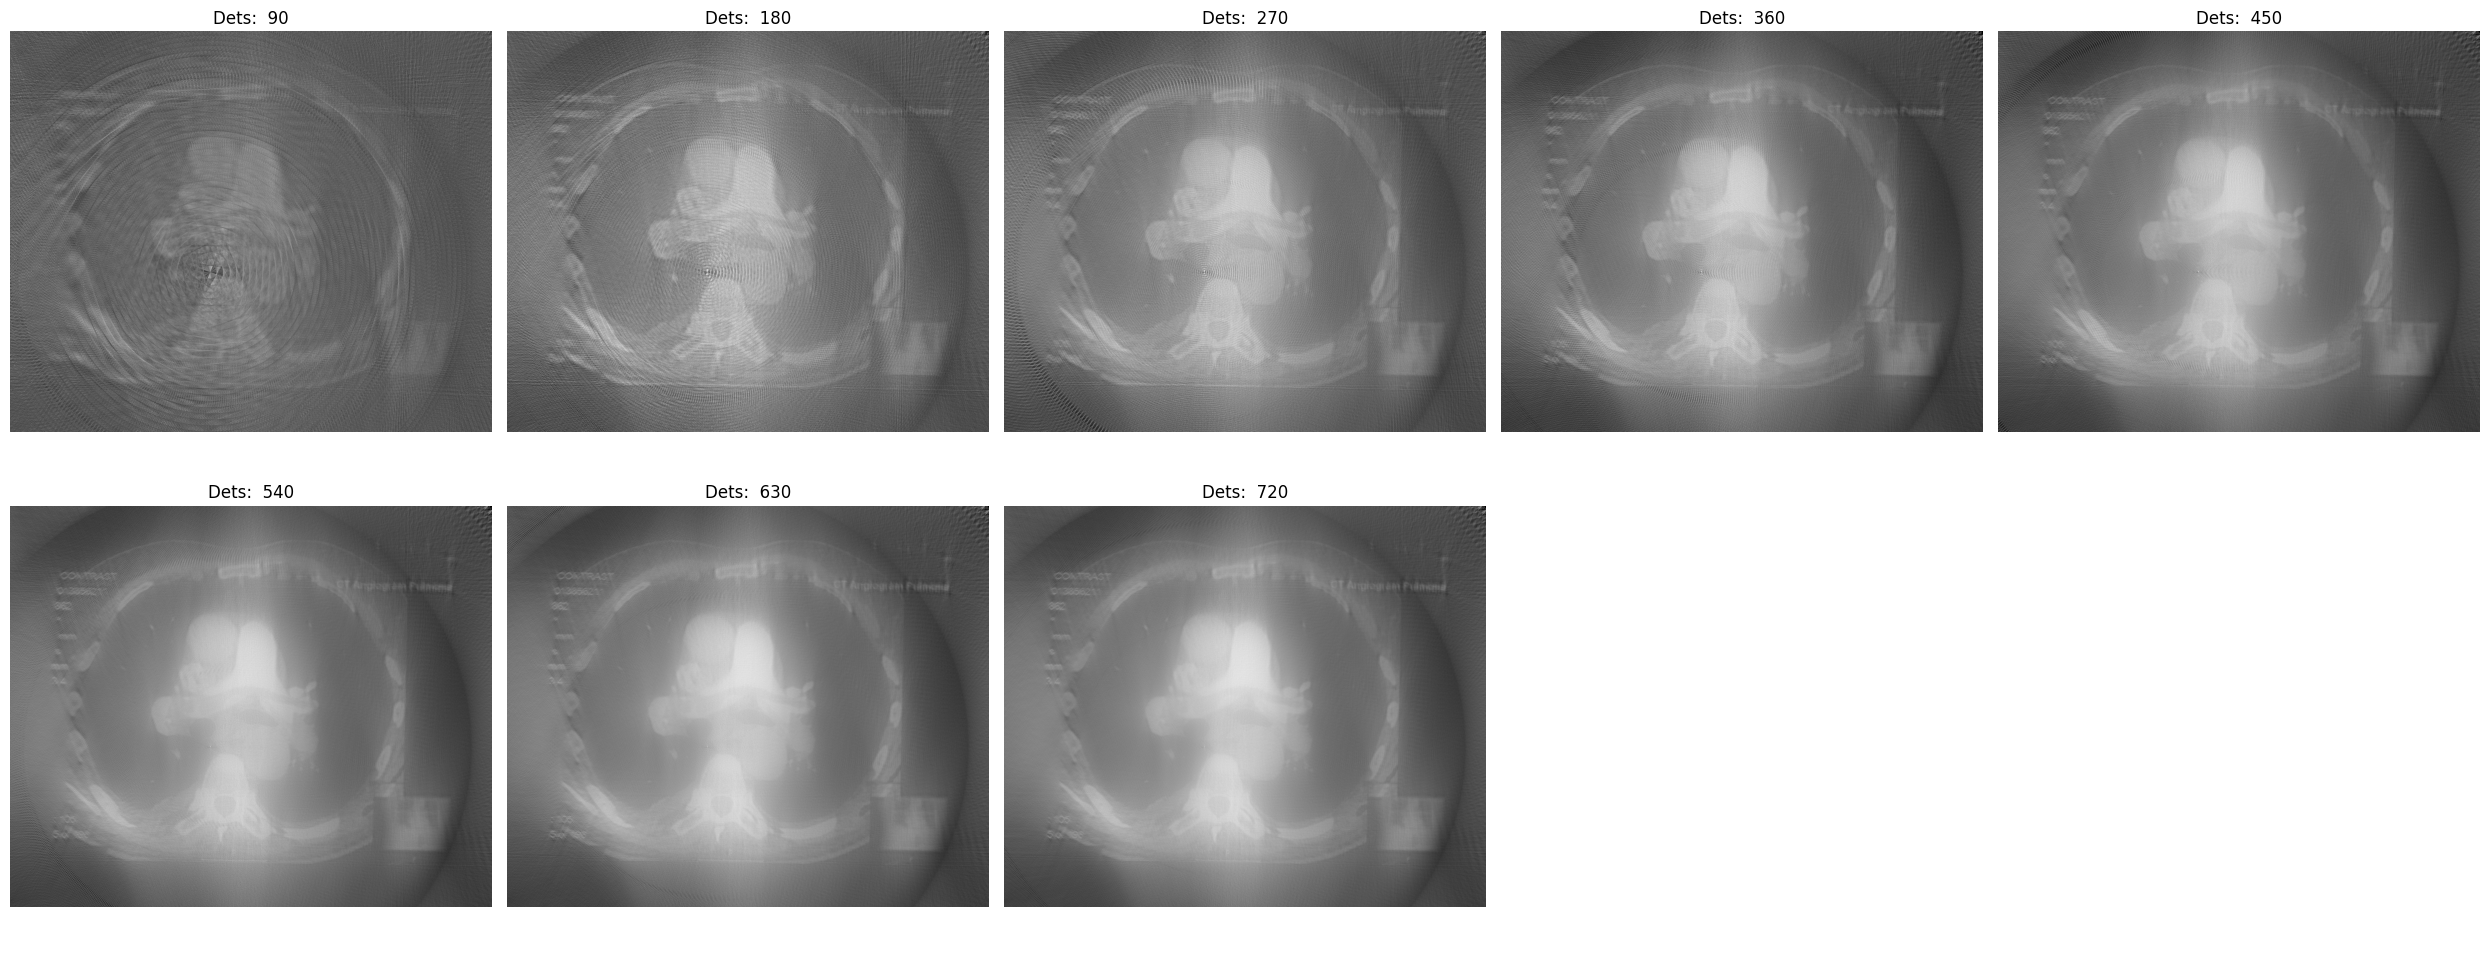

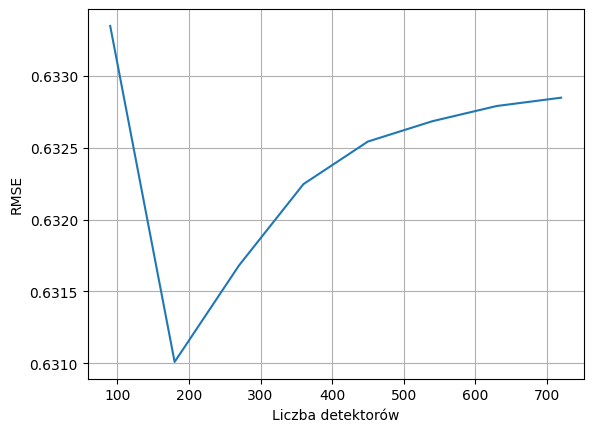

0.6380
0.6310
0.6278
0.6263
0.6248
0.6265
0.6265
0.6262


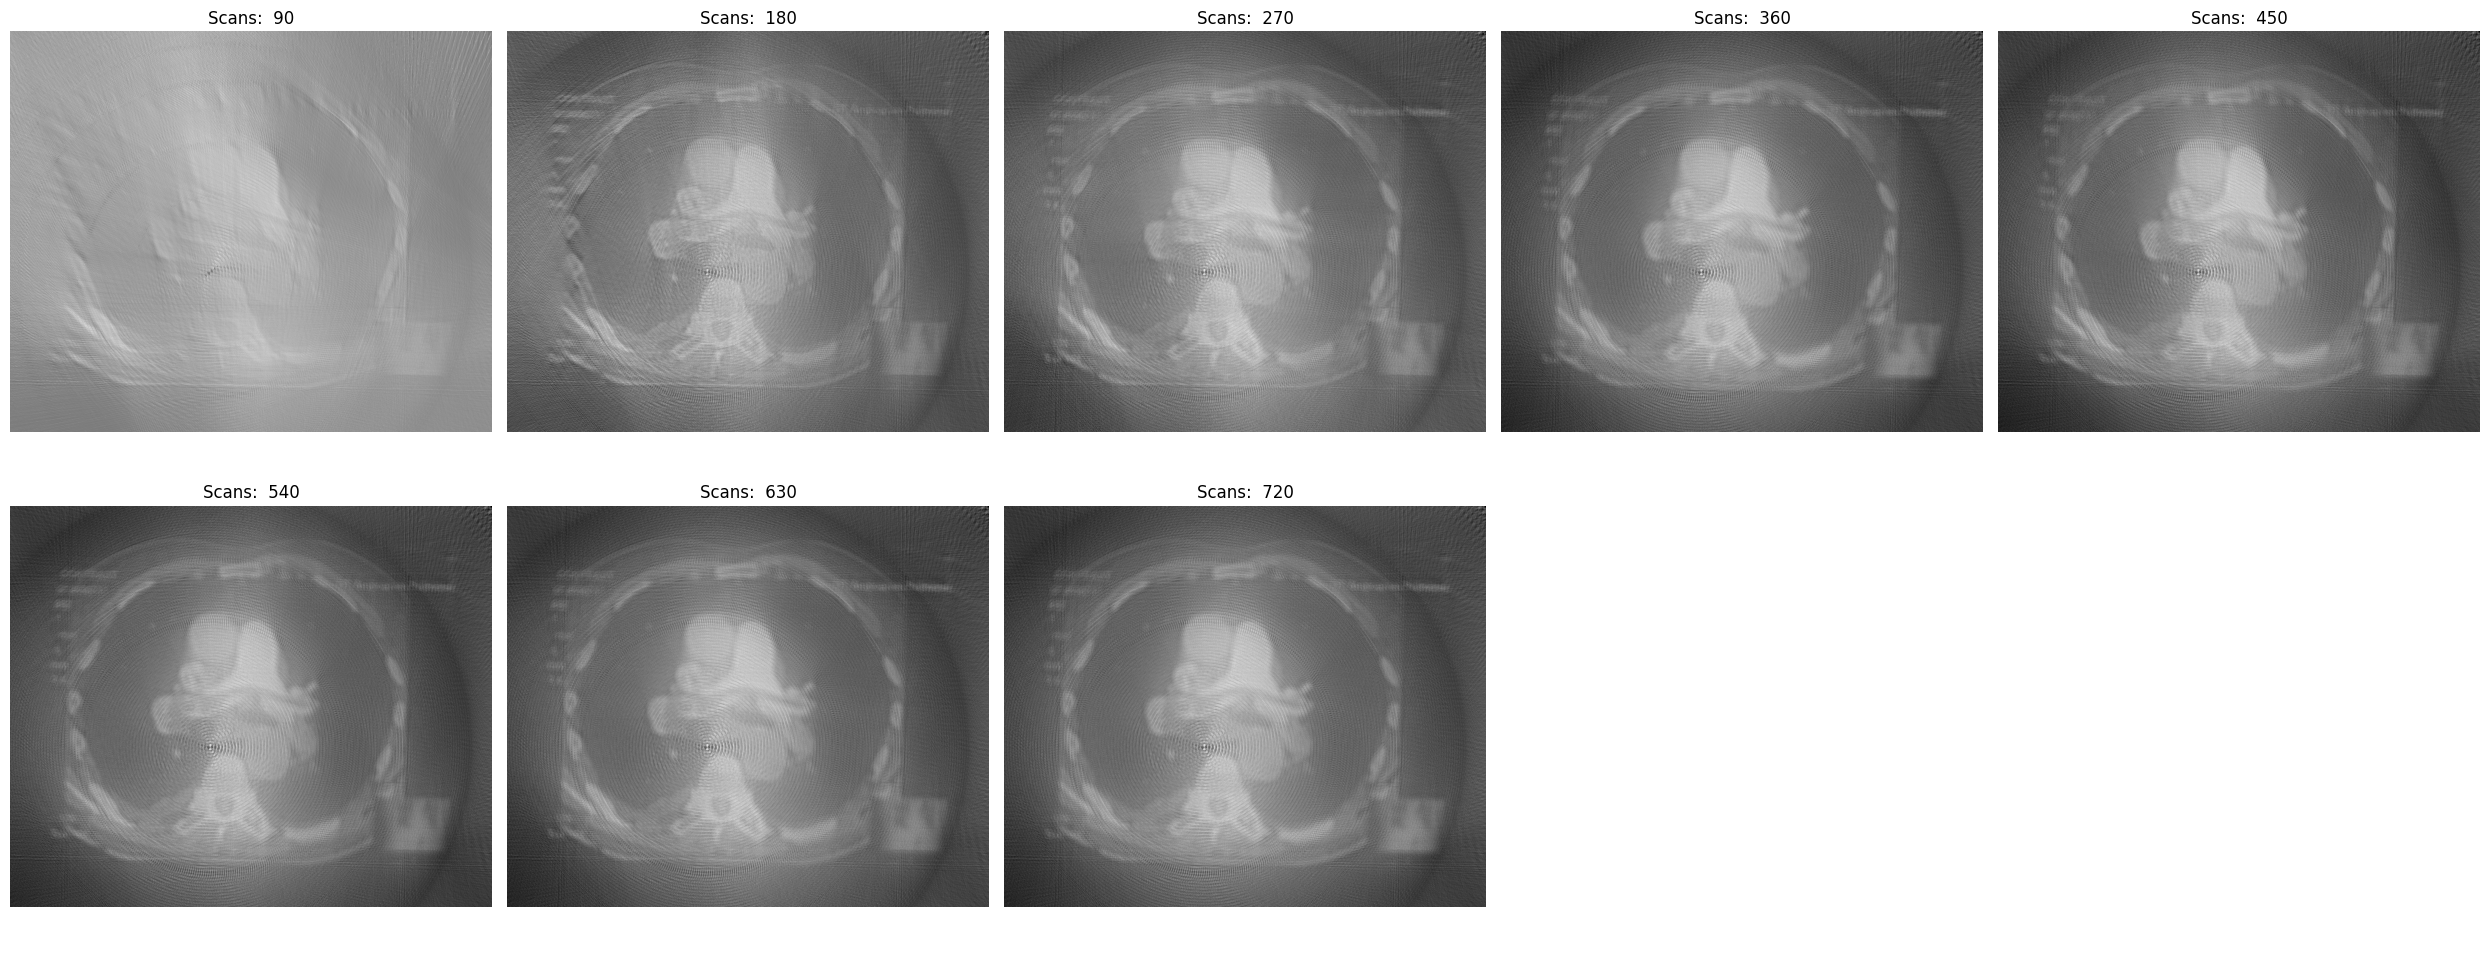

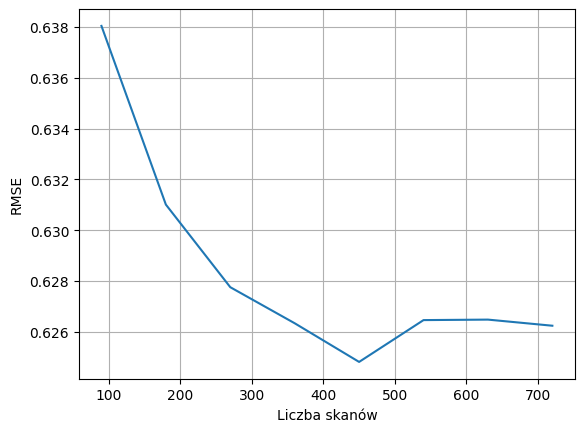

0.7168
0.6740
0.6489
0.6310
0.6270
0.6266


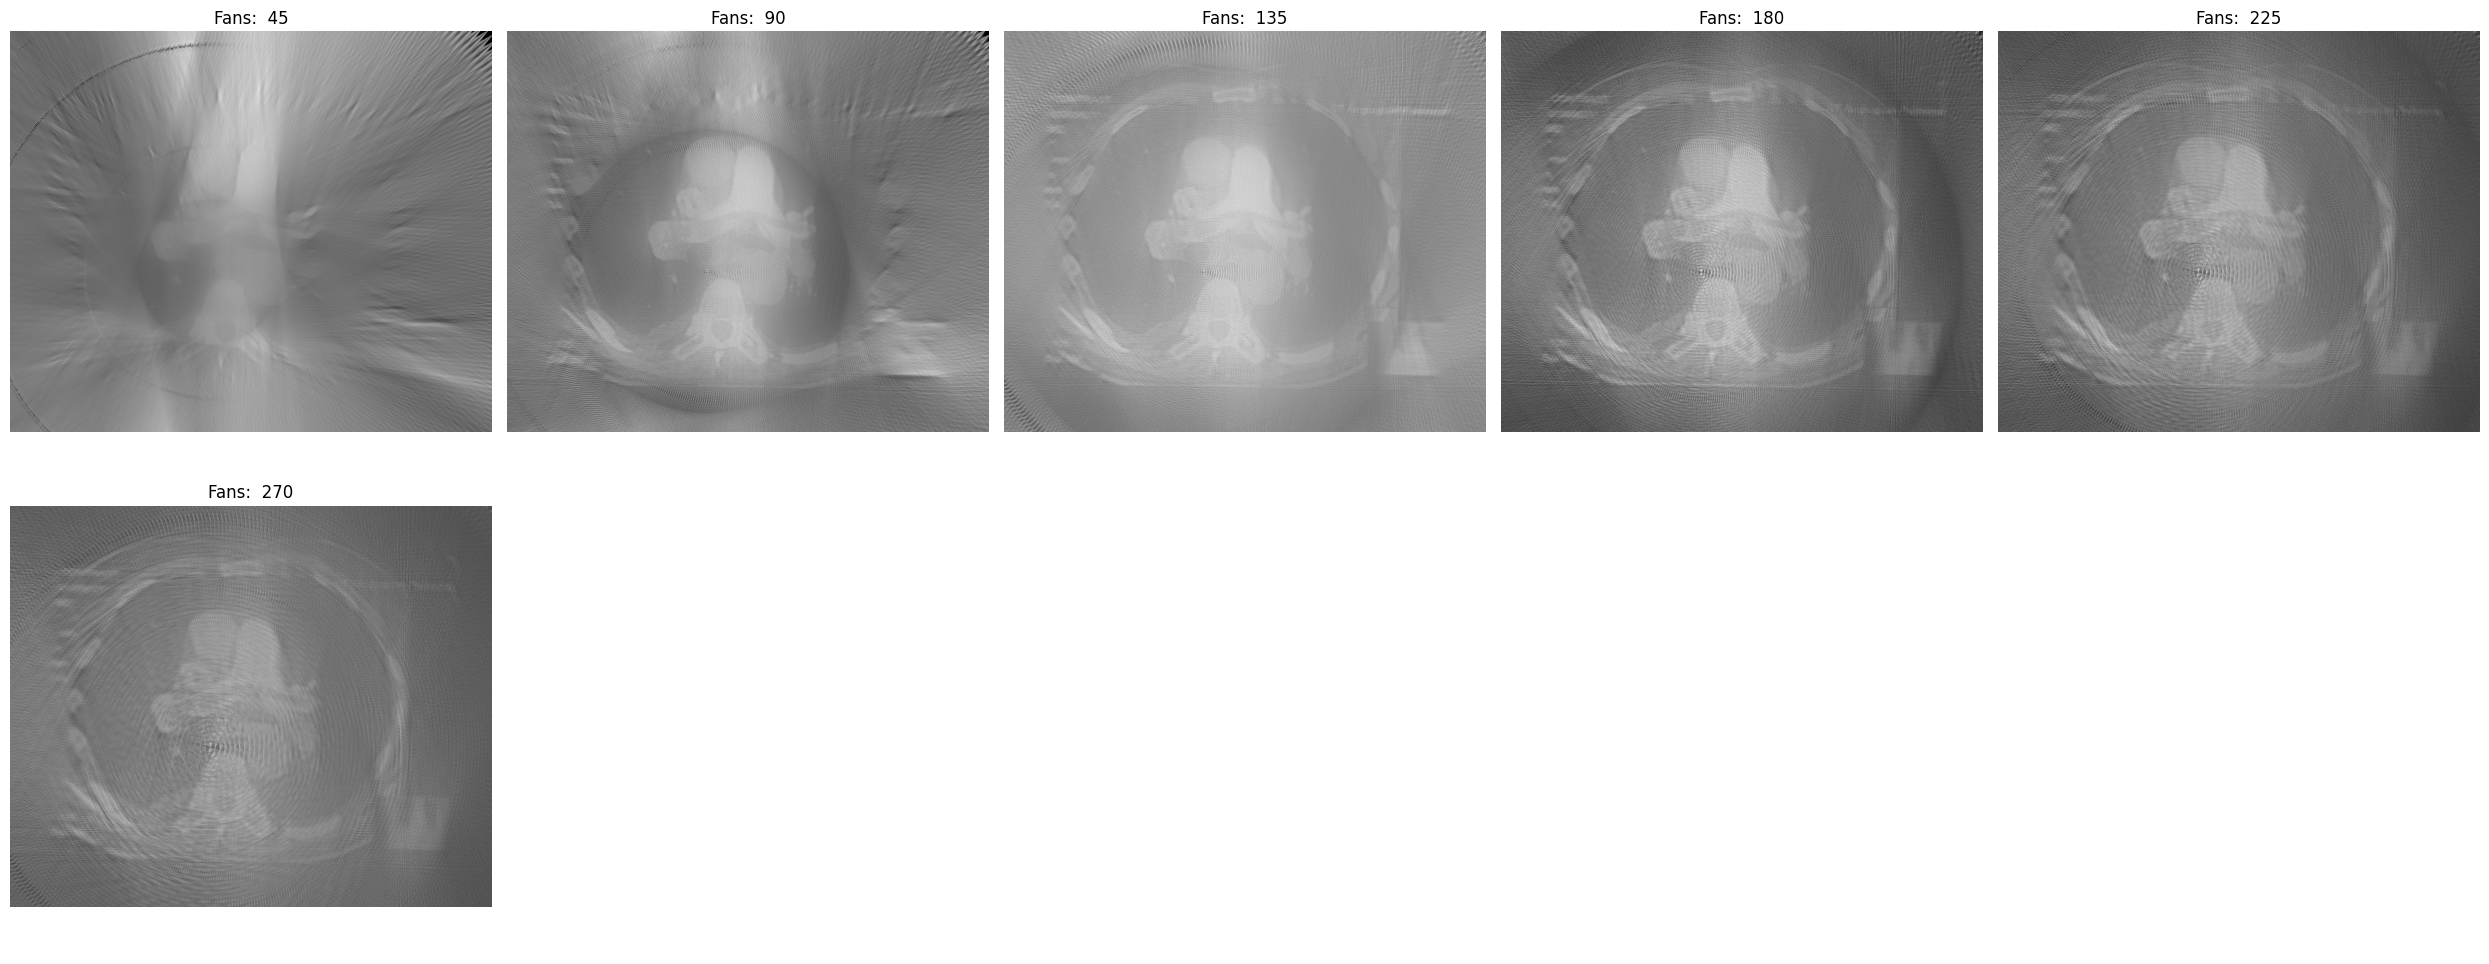

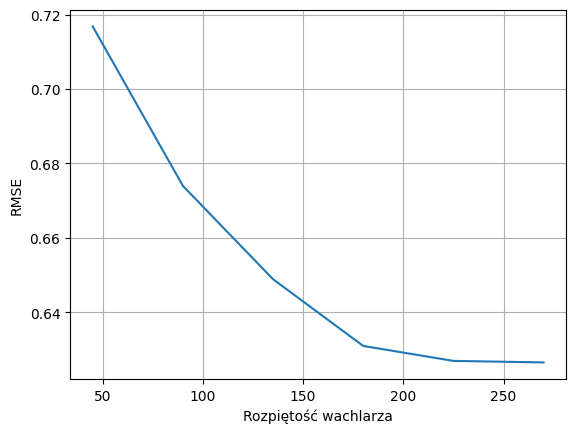

In [ ]:
### BASIC ###
# dets - 180
# scans - 180
# fan - 180

dets = [i for i in range(90, 721, 90)]
scans = [i for i in range(90, 721, 90)]
fans = [i for i in range(45, 271, 45)]

temp_images = []

def draw_plt(temp_images, fd, title):
    num_plots = len(temp_images)
    cols = 5
    rows = (num_plots // cols) + (num_plots % cols > 0)  
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    axes = axes.flatten()
    for idx, img in enumerate(temp_images):
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"{title} {fd[idx]}")
        axes[idx].axis('off')  

    for j in range(num_plots, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    temp_images = []

rmse_dets = []
rmse_scans = []
rmse_fans = []

# test_img = np.array(Image.open("./example-data/png/Shepp_logan.jpg").convert("L"))
test_img = mpimg.imread("./example-data/png/SADDLE_PE-large.jpg")
if len(test_img.shape) == 3:
    test_img = np.mean(test_img, axis=2)
    
_, _, fixed_radius = compute_geometry(test_img.shape, margin=0.0)

def calc_RMSE(org, rec):
    return np.sqrt(np.mean((org - rec) ** 2))/100

for d in dets:
    sin = radon_transform(test_img, 1, d, 180,'TEST', 180, False, fixed_radius=fixed_radius)[0]
    rec = inverse_radon_transform(sin, test_img.shape, 1, 180,'TEST', False, filter_sinogram=True, fixed_radius=fixed_radius)
    temp_images.append(rec)
    rmse = calc_RMSE(test_img, rec)
    print(f"{rmse:.4f}")
    rmse_dets.append(rmse)

draw_plt(temp_images, dets, "Dets: ")
temp_images = []

plt.figure()
plt.plot(dets, rmse_dets, label='RMSE dla detektorów')
plt.xlabel('Liczba detektorów')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

for s in scans:
    sin = radon_transform(test_img, 1, 180, 180,'TEST', s, False, fixed_radius=fixed_radius)[0]
    rec = inverse_radon_transform(sin, test_img.shape, 1, 180,'TEST', False, filter_sinogram=True,fixed_radius=fixed_radius)
    temp_images.append(rec)
    rmse = calc_RMSE(test_img, rec)
    print(f"{rmse:.4f}")
    rmse_scans.append(rmse)

draw_plt(temp_images, scans,"Scans: ")
temp_images = []

plt.figure()
plt.plot(scans, rmse_scans, label='RMSE dla skanów')
plt.xlabel('Liczba skanów')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

for f in fans:
    sin = radon_transform(test_img, 1, 180, f,'TEST', 180, False, fixed_radius=fixed_radius)[0]
    rec = inverse_radon_transform(sin, test_img.shape, 1, f,'TEST', False,filter_sinogram=True, fixed_radius=fixed_radius)
    temp_images.append(rec)
    rmse = calc_RMSE(test_img, rec)
    print(f"{rmse:.4f}")
    rmse_fans.append(rmse)

draw_plt(temp_images, fans, "Fans: ")
temp_images = []

plt.figure()
plt.plot(fans, rmse_fans, label='RMSE dla rozpętości wachlarza')
plt.xlabel('Rozpiętość wachlarza')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


<p> <b> Zwiększanie liczby detektorów, a RMSE </b> - wynik sugeruje nam, że przy większej liczbie detektorów rekonstrukcja staje się bardziej skomplikowana, co może oddziaływac na poprawność rekonstrukcji obrazu. Widzimy również, że z podanych parametrów wartość 180 jest najlepsza pod względem wyników. </p>
<p> <b>Zwiększanie liczby skanów, a RMSE</b> - dodatkowe skany pozwalają do precyzyjnej rekonstrukcji obrazu. </p>
<p> <b>Zwiększanie rozpiętości wachlarza, a RMSE</b> - szerszy kąt rozpiętości pozwala na uchwycenie lepszej jakości obrazu. </p>

<h1> RMSE w iteracjach odwrotnej transformaty Radona </h1>
<p> Spadek błędu średniokwadratowego w iteracjach odwrotnej transformaty Radona, świadczy o poprawności algorytmu, gdyż obraz z każdą iteracją staje się coraz to bardziej zgodny z rzeczywistym obrazem. </p>

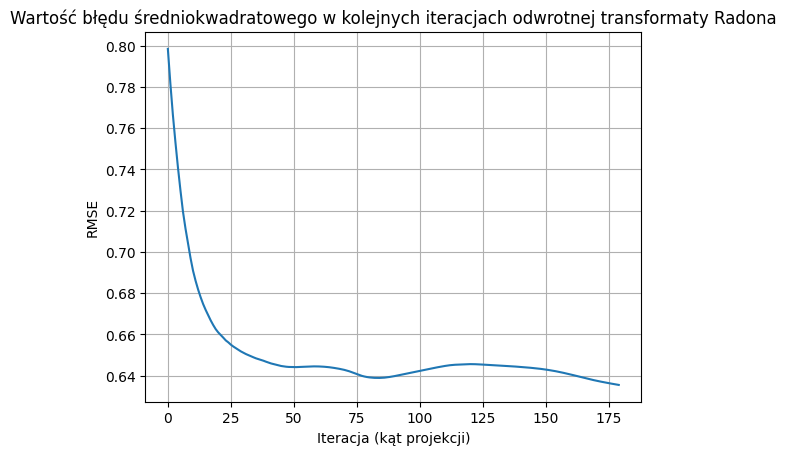

In [ ]:
bladI = []

test_img = mpimg.imread("./example-data/png/SADDLE_PE-large.jpg")
if test_img.ndim == 3:  
    test_img = np.mean(test_img, axis=2)

sinogram = radon_transform(test_img, 1, 180, 180,'TEST', 180, False, fixed_radius=fixed_radius)[0]
rec_img, bladI = inverse_radon_transform( sinogram, test_img.shape, 1, 180, "rekonstrukcja_iteracyjna", show_plt=False, original_image=test_img)

plt.plot(bladI)
plt.title("Wartość błędu średniokwadratowego w kolejnych iteracjach odwrotnej transformaty Radona")
plt.xlabel("Iteracja (kąt projekcji)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

<h1> Badanie zależności wyników rekonstrukcji od filtracji </h1>
<p> Możemy zauważyć bez większych zastrzeżeń, że przy filtracji sinogramu, nasza rekonstrukcja staje się bardziej dokładna i wyrazista. Obraz staje się jednak nieco bardziej jednorodny tonalnie – przyjmuje odcienie szarości, co może prowadzić do utraty lokalnych kontrastów. W rezultacie, mimo lepszego wyglądu subiektywnego, wzrasta wartość RMSE ze względu na większe odchylenia od oryginalnych wartości pikseli. </p>

Shepp-Logan – RMSE bez filtrowania: 0.4912, z filtrowaniem: 0.6273


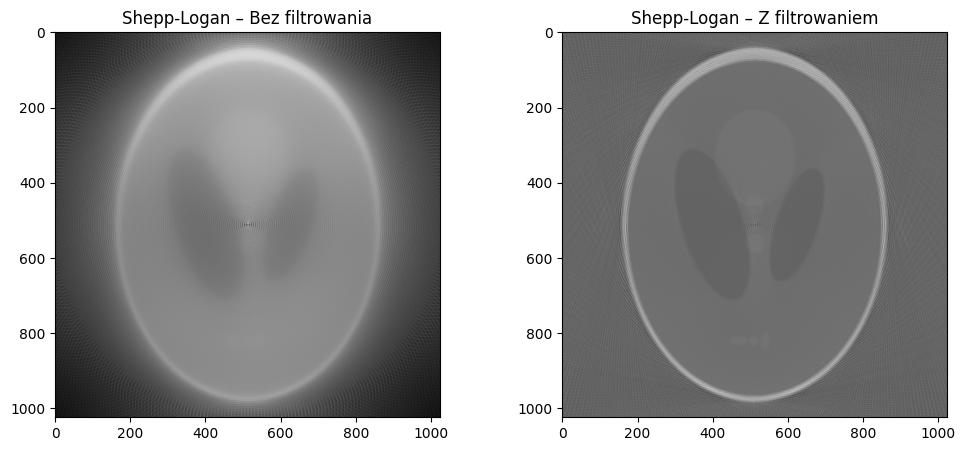

SADDLE_PE – RMSE bez filtrowania: 0.6287, z filtrowaniem: 0.8144


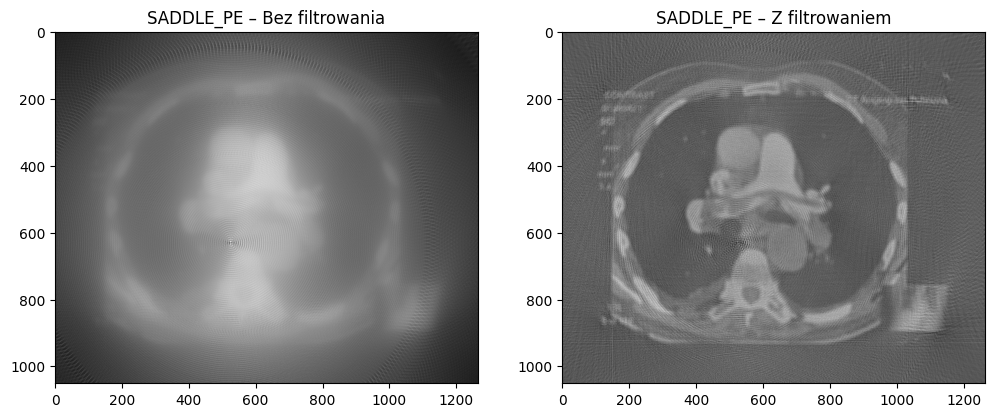

In [ ]:
d = 360
s = 360
f = 270

img1 = mpimg.imread("./example-data/png/Shepp_logan.jpg")
img2 = mpimg.imread("./example-data/png/SADDLE_PE-large.jpg")
imgs = [img1, img2]
titles = ["Shepp-Logan", "SADDLE_PE"]

for idx, img in enumerate(imgs):
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)
    _, _, fixed_radius = compute_geometry(img.shape, margin=0.0)

    sin = radon_transform(img, 1, d, f, 'TEST', s, False, fixed_radius=fixed_radius)[0]
    rec_unfiltered = inverse_radon_transform(sin, img.shape, 1, f, 'TEST', False, filter_sinogram=False, fixed_radius=fixed_radius)
    rec_filtered = inverse_radon_transform(sin, img.shape, 1, f, 'TEST',False,  filter_sinogram=True, fixed_radius=fixed_radius)

    rmse_unfiltered = calc_RMSE(img, rec_unfiltered)
    rmse_filtered = calc_RMSE(img, rec_filtered)

    print(f"{titles[idx]} – RMSE bez filtrowania: {rmse_unfiltered:.4f}, z filtrowaniem: {rmse_filtered:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rec_unfiltered, cmap='gray')
    plt.title(f'{titles[idx]} – Bez filtrowania')

    plt.subplot(1, 2, 2)
    plt.imshow(rec_filtered, cmap='gray')
    plt.title(f'{titles[idx]} – Z filtrowaniem')
    plt.show()